In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
RECOMPUTE_ALL = False

In [3]:
try:
    _ = __IPYTHON__
    IN_JUPYTER_NOTEBOOK = True
except Exception:
    IN_JUPYTER_NOTEBOOK = False

print(f'{IN_JUPYTER_NOTEBOOK = }')

IN_JUPYTER_NOTEBOOK = True


In [4]:
import torch
from torch import nn
import torchvision

import numpy as np
from matplotlib import pyplot as plt

import sys
import os
import random

if IN_JUPYTER_NOTEBOOK:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

In [5]:
from src.commandline import parse_args, args_to_string, get_view_idx_string, get_free_gpu_memory
from src.dataset.gtav import load_gta_v_data
from src.dataset.blender import load_blender_data
from src.dataset.image import scale_images
from src.dataset.rays import get_ray_dataloader, estimate_scene_normalization
from src.model.encoding import PositionalEncoding, IntegratedPositionalEncoding, SphericalHarmonicsEncoding
from src.model.encoding import RaySegmentToMidpointWrapper, MultiResolutionHashGridEncoding, MultiResolutionHashGridEncodingTCNN
from src.model.encoding import contract_fn
from src.model.model import RadianceField, RadianceFieldAsDensityField, DensityField, LambdaLayer, softplus_mod, sigmoid_mod
from src.model.scene import NeRFScene, run_scene, unflatten_estims, ConstantBackground
from src.visualization import show_estims, show_history
from src.victor.datasets import load_default_data
import numpy as np
from scipy.spatial import KDTree

No module named 'tinycudann' Warning, could not load tinycudann.


In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
DEFORMATION_INIT_PATH = "nets/def_init_test.net"
DEFORMATION_PATH      = "nets/def_test.net"

In [8]:
# --- Arguments to use if run from notebook ---

# Predefined (partial) setups

hash_enc_args = [
    '--learningrate 1e-2',
    '--lrdecaysteps 15000',
    '--lrdecayrate 0.5',
    '--weightdecay 1e-6',

    '--posenc hash',
    '--hiddensize 64',
    '--blocks 1',
    '--blocksize 2',

    '--epochs 10',
    '--saveevery 1',

    '--tablesize 19',
]

pe_enc_args = [
    '--learningrate 5e-4',

    '--posenc pe',
    '--posres 14',

    '--epochs 100',
    '--saveevery 10',
]

ipe_enc_args = [
    '--learningrate 5e-4',

    '--posenc ipe',
    '--posres 14',

    '--epochs 100',
    '--saveevery 10',
]

synthetic_lego_args = [
    '--dataset /clusterarchive/NeRF/nerf_synthetic/lego',
    '--scenescale 0.25',
    '--near 0.5',
    '--far 1.5',
    '--valviews ' + get_view_idx_string(100, 130),
    '--posres 12',
]

gtav_beach_20m_args = [
    '--dataset /clusterarchive/NeRF/gta-v/gta-v-beach-20m',
    '--scenecenter -1384.30 -1550.35 13.46',
    '--scenescale 0.01',
    '--near 0.0001',
    #'--far 0.6',
    '--trainviews ' + get_view_idx_string(0, 380),
    '--valviews ' + get_view_idx_string(380, 400),
    '--posres 16',
]

gtav_farm_60m_args = [
    '--dataset /clusterarchive/NeRF/gta-v/gta-v-farm-60m',
    '--scenecenter 1941.02 4636.21 72.70',
    '--scenescale 0.004',
    '--near 0.00001',
    #'--far 0.6',
    '--trainviews ' + get_view_idx_string(0, 380),
    '--valviews ' + get_view_idx_string(380, 400),
    '--posres 18',
    '--distreg 0.001',
]

gtav_harbor_50m_args = [
    '--dataset /clusterarchive/NeRF/gta-v/gta-v-harbor-50m',
    '--scenecenter 844.53 -3091.99 32.76',
    '--scenescale 0.004',
    '--near 0.00001',
    #'--far 0.6',
    '--trainviews ' + get_view_idx_string(0, 380),
    '--valviews ' + get_view_idx_string(380, 400),
    '--posres 18',
]

gtav_filmset_cameraman_args = [
    '--dataset /clusterarchive/NeRF/gta-v/gta-v-filmset-cameraman',
    '--scenecenter -1184.51 -496.44 37.34',
    '--scenescale 0.01',
    '--near 0.0001',
    #'--far 0.6',
    '--trainviews ' + get_view_idx_string(0, 19),
    '--valviews ' + get_view_idx_string(19, 20),
    '--posres 16',
]


if False:
    gtav_harbour_args = [
        '--dataset /clusterarchive/NeRF/gta-v/gta-v-harbor-50m',
        '--scenecenter -1184.51 -496.44 37.34',
        '--scenescale 0.01',
        '--near 0.0001',
        #'--far 0.6',
        '--trainviews ' + get_view_idx_string(0, 19),
        '--valviews ' + get_view_idx_string(19, 20),
        '--posres 16',
    ]

gtav_real_args = [
    '--dataset /clusterarchive/NeRF/gta-v/gta-v-harbor-50m',
    '--scenecenter -1184.51 -496.44 37.34',
    '--scenescale 0.001',
    '--near 0.0001',
    #'--far 0.6',
    '--trainviews ' + get_view_idx_string(0, 19),
    '--valviews ' + get_view_idx_string(19, 20),
    '--posres 16',
]


seminar_args = [
    '--dataset /clusterarchive/NeRF/drone-footage/seminar',
    #'--scenecenter -1184.51 -496.44 37.34',
    '--scenescale 0.01',
    '--near 0.0001',
    '--far 2.0',
    #'--contract',
    ##'--trainviews ' + get_view_idx_string(0, 19),
    ##'--valviews ' + get_view_idx_string(19, 20),
    '--trainviews ' + get_view_idx_string(0, 113),
    '--valviews ' + get_view_idx_string(0, 113, 10),
    '--posres 16',
    '--distreg 0.001',
]

unbound_args = [
    '--contract',
    '--far 2',
]

# -- Build arguments here --

nb_args = []

nb_args += hash_enc_args

# NOTE: set to one of the datasets above beach/farm/harbor/filmset/...
#nb_args += gtav_harbour_50m_args
#nb_args += gtav_farm_60m_args
#nb_args += seminar_args
nb_args += gtav_beach_20m_args
#nb_args += gtav_filmset_cameraman_args

nb_args += unbound_args # NOTE: for largescale scenes like the GTA ones, uncomment this! maps [-inf, inf] to [-1, 1]

nb_args += [
    #'--posenc tcnnhash', # NOTE: uncomment if tinycudann is installed for large speedup
    #'--background skybox', # NOTE: optional, --contract gives better density values
    '--batchsize 8192',
    #'--imagescale 0.5',
    '--imagescale 0.25',#0.1',
    #'--imagescale 1.0',
    #'--posenc tcnnhash',
]

# -- End build arguments here --

# ---------------------------------------------

nb_args = ' '.join(nb_args).split()

if IN_JUPYTER_NOTEBOOK:
    # Delete jupyter stuff from args
    sys.argv = ['Jupyter Notebook'] + nb_args

# Parse and print args
args = parse_args()

header = '--- Arguments ---'
print(header + '\n' + args_to_string(args) + '\n' + '-' * len(header))

--- Arguments ---
dataset:       /clusterarchive/NeRF/gta-v/gta-v-beach-20m
scenecenter:   [-1384.3, -1550.35, 13.46]
scenescale:    0.01
imagescale:    0.25
trainstart:    0
trainsize:     None
trainviews:    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,

In [9]:
# Make project folder

os.makedirs(args.saveckpt, exist_ok=True)
print('Running in folder', args.saveckpt)

Running in folder results/default


In [10]:
# Load data

if 'seminar' in args.dataset:
    images, c2ws, (focal_x, focal_y), *_ = load_default_data(args.dataset)
    images = images[None]
    c2ws = c2ws[None] 

elif 'gta-v' in args.dataset:
    images, c2ws, (focal_x, focal_y), *_ = load_gta_v_data(args.dataset)

elif 'nerf_synthetic' in args.dataset:
    train_images, train_c2ws, (focal_x, focal_y) = load_blender_data(args.dataset, split='train')
    val_images, val_c2ws, *_ = load_blender_data(args.dataset, split='val')

    num_train = len(train_images)
    num_val = len(val_images)

    images = torch.cat((train_images, val_images))[None]
    c2ws = torch.cat((train_c2ws, val_c2ws))[None] 

    if args.trainviews is None:
        args.trainviews = list(range(num_train))
        print(f'Using original trainviews from {args.trainviews[0]} to {args.trainviews[-1]}')

    if args.valviews is None:
        args.valviews = list(range(num_train, num_train + num_val))
        print(f'Using original valviews from {args.valviews[0]} to {args.valviews[-1]}')

else:
    assert False, f'{args.dataset = } not supported'

print(f'Loaded dataset with initial {images.shape = }')

Loading GTA V data:   0%|          | 0/400 [00:00<?, ?it/s]

Loaded dataset with initial images.shape = torch.Size([1, 400, 600, 800, 3])


In [11]:
estimators = estimate_scene_normalization(c2ws, 
                                          images.shape[-3], 
                                          images.shape[-2], 
                                          focal_x, 
                                          focal_y)
print('---- Estimators for scene normalization:', *estimators.items(), '-----', sep='\n')

---- Estimators for scene normalization:
('aabb_min', [-1403.9940185546875, -1569.967041015625, 4.534426212310791])
('aabb_max', [-1364.614990234375, -1530.7349853515625, 22.388980865478516])
('scene_center', [-1384.304443359375, -1550.35107421875, 13.461703300476074])
('scene_scale', 0.012462385930120945)
('far', 46.1229133605957)
('scaled_far', 0.5748015642166138)
-----


In [12]:
# Scale images

images = scale_images(images, args.imagescale)

focal_x *= args.imagescale
focal_y *= args.imagescale

print(f'Final {images.shape = } ({focal_x = }, {focal_y = })')

num_steps, num_views, height, width, num_channels = images.shape
assert num_channels == 3

Resizing images:   0%|          | 0/400 [00:00<?, ?it/s]

Final images.shape = torch.Size([1, 400, 150, 200, 3]) (focal_x = 160.8380190382169, focal_y = 160.8380190382169)


In [13]:
# Center and scale scene

c2ws[..., :3, -1] -= torch.tensor(args.scenecenter)
print(f'Applied scene centering by {args.scenecenter = }.')

c2ws[..., :3, -1] *= args.scenescale
print(f'Applied scene scaling by {args.scenescale = }.')

Applied scene centering by args.scenecenter = [-1384.3, -1550.35, 13.46].
Applied scene scaling by args.scenescale = 0.01.


In [14]:
# Set train and validation split if not given

if args.trainsize is None:
    args.trainsize = len(images) - args.trainstart
    print(f'Automatic {args.trainsize = }')

if args.trainviews is None:
    args.trainviews = list(range(num_views))
    print(f'Automatic {args.trainviews = }')

if args.valviews is None:
    args.valviews = args.trainviews[::10]
    print(f'Automatic {args.valviews = }')

Automatic args.trainsize = 1


In [15]:
def get_encoder(name, 
                resolution, 
                log2_hash_table_size=19, 
                num_levels=16,
                encode_segments=True, 
                contract=False,):

    if name == 'pe':
        encoder = PositionalEncoding(resolution)

        if encode_segments:
            encoder = RaySegmentToMidpointWrapper(encoder, (lambda x: contract_fn(x, 2) / 2) if contract else None)

        enc_size = 2 * 3 * resolution

    elif args.direnc =='sh':
        encoder = SphericalHarmonicsEncoding(args.dirres)
        enc_size = resolution ** 2

    elif name == 'hash':
        encoder = MultiResolutionHashGridEncoding(num_features_in=3,
                                                  num_levels=num_levels, 
                                                  log2_hash_table_size=log2_hash_table_size,
                                                  max_resolution=2 ** resolution)

        if encode_segments:
            encoder = RaySegmentToMidpointWrapper(encoder, (lambda x: contract_fn(x, torch.inf) / 2) if contract else None)

        enc_size = 2 * num_levels

    elif name == 'tcnnhash':
        encoder = MultiResolutionHashGridEncodingTCNN(num_features_in=3,
                                                      num_levels=num_levels, 
                                                      log2_hash_table_size=log2_hash_table_size,
                                                      max_resolution=2 ** resolution)
        if encode_segments:
            encoder = RaySegmentToMidpointWrapper(encoder, (lambda x: contract_fn(x, torch.inf) / 2) if contract else None)

        enc_size = 2 * num_levels

    else:
        assert False, f'Encoding {name} is unknown (NOTE: mip needs rays_d normalization adjustment)'

    return encoder, enc_size

In [16]:
activations = {
    'activation': nn.ReLU,
    'density_activation': lambda x: torch.exp(x - 1),
    'color_activation': sigmoid_mod,
}

In [17]:
# Build density field
d_poss_encoder, d_poss_enc_size = get_encoder(args.posenc, 
                                              args.posres - 2, 
                                              log2_hash_table_size=args.tablesize - 2, 
                                              num_levels=args.gridlevels // 2,
                                              contract=args.contract)

density_field = DensityField(d_poss_encoder, 
                             d_poss_enc_size,
                             hidden_size=args.hiddensize,
                             **activations)

BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.


In [18]:
# Build radiance field

r_pos_encoder, r_pos_enc_size = get_encoder(args.posenc, 
                                            args.posres, 
                                            log2_hash_table_size=args.tablesize, 
                                            num_levels=args.gridlevels,
                                            contract=args.contract)

r_dir_encoder, r_dir_enc_size = get_encoder(args.direnc, args.dirres, encode_segments=False)

radiance_field = RadianceField(pos_encoder=r_pos_encoder,
                               pos_enc_size=r_pos_enc_size,
                               dir_encoder=r_dir_encoder,
                               dir_enc_size=r_dir_enc_size,
                               hidden_size=args.hiddensize,
                               num_blocks=args.blocks,
                               block_size=args.blocksize,
                               **activations)

BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.
BaseGridEncoding: Use PyTorch >= 2.0 for speedup.


In [19]:
# Background model

if args.background is None:
    background_model = None

elif args.background == 'white':
    background_model = ConstantBackground(torch.tensor([1, 1, 1]))

elif args.background == 'black':
    background_model = ConstantBackground(torch.tensor([0, 0, 0]))

elif args.background == 'skybox':
    bgencoder, bgenc_size = get_encoder('pe', 6, segment2midpoint=False)
    background_model = nn.Sequential(bgencoder,
                                     nn.Linear(bgenc_size, 32), 
                                     nn.LeakyReLU(), 
                                     nn.Linear(32, 32), 
                                     nn.LeakyReLU(), 
                                     nn.Linear(32, 3), 
                                     LambdaLayer(lambda x: sigmoid_mod(x)))
else:
    assert False, f'{args.background = } unknown'

In [20]:
# Full scene

scene = NeRFScene(radiance_fields=[radiance_field],
                  num_samples=[args.samples[-1]],
                  density_fields=[density_field],
                  num_density_samples=[args.samples[0]],
                  near=args.near,
                  far=args.far,
                  background_model=background_model,)

num_params = sum(p.numel() for p in scene.parameters() if p.requires_grad)
print(f'Scene has {num_params} trainable parameters.')

# Multi GPU

free_mem = get_free_gpu_memory()
assert len(free_mem) >= args.gpus

gpu_ids = free_mem.argsort(descending=True)[:args.gpus]
print(f'Found free GPU memory {free_mem.tolist()} - choosing devices {gpu_ids.tolist()}.')

scene = scene.cuda()
scene = nn.DataParallel(scene, gpu_ids)

print('\n\n Full scene module:\n\n', scene)

Scene has 15656368 trainable parameters.
Found free GPU memory [23761] - choosing devices [0].


 Full scene module:

 DataParallel(
  (module): NeRFScene(
    (radiance_fields): ModuleList(
      (0): RadianceField(
        (pos_encoder): RaySegmentToMidpointWrapper(
          (point_encoder): MultiResolutionHashGridEncoding(
            (multi_resolution_grids): ModuleList(
              (0): FullGridEncoding()
              (1): FullGridEncoding()
              (2): FullGridEncoding()
              (3): HashGridEncoding()
              (4): HashGridEncoding()
              (5): HashGridEncoding()
              (6): HashGridEncoding()
              (7): HashGridEncoding()
              (8): HashGridEncoding()
              (9): HashGridEncoding()
              (10): HashGridEncoding()
              (11): HashGridEncoding()
              (12): HashGridEncoding()
              (13): HashGridEncoding()
              (14): HashGridEncoding()
              (15): HashGridEncoding()
       

In [21]:
# Optimizer

# Exclude encoder entries from weight decay (see INGP for reference)
param_groups = [
    {
        'params': [param for name, param in scene.named_parameters() if 'encoder' in name],
        'weight_decay': 0,
    },
    {
        'params': [param for name, param in scene.named_parameters() if 'encoder' not in name],
        'weight_decay': args.weightdecay,
    }
]

print('Params without weight decay:', len(param_groups[0]['params']))

# Betas and eps from https://nvlabs.github.io/instant-ngp/assets/mueller2022instant.pdf
optim = torch.optim.Adam(
    param_groups, 
    lr=args.learningrate,
    eps=1e-15, 
    betas=[0.9, 0.99], 
)

if args.lrdecaysteps is not None:
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                                   args.lrdecaysteps, 
                                                   args.lrdecayrate)
    print(f'Using LR decay with stepsize {args.lrdecaysteps} and rate {args.lrdecayrate}')
else:
    lr_scheduler = None

# These are initialized with model
history = {'train': [], 'val': [], 'final_epochs': []}

Params without weight decay: 24
Using LR decay with stepsize 15000 and rate 0.5


In [22]:
if args.loadckpt is not None:
    
    ckpt = torch.load(args.loadckpt)

    scene.load_state_dict(ckpt['scene'])
    optim.load_state_dict(ckpt['optim'])

    print(f'Loaded checkpoint {args.loadckpt}')

    if ckpt['lr_scheduler'] is not None:
        print(f'Warning, scheduler at step {lr_scheduler.step} is not loaded. Please setup manually!')

In [23]:
def save_checkpoint(path):

    global scene, optim, history

    ckpt = {
        'scene': scene.state_dict(),
        'optim': optim.state_dict(),
        'history': history,
    }

    if lr_scheduler is not None:
        ckpt['lr_scheduler'] = lr_scheduler.state_dict()

    torch.save(ckpt, path)

In [24]:
def get_dataloader(step_idx=None, view_idx=None, shuffle=False, patch_size=1, c2ws=None, val_topdown=False):

    if c2ws is None:
        c2ws = globals()['c2ws']
    
    return get_ray_dataloader(images,
                              c2ws,
                              focal_x,
                              focal_y,
                              step_idx,
                              view_idx,
                              shuffle=shuffle,
                              batch_size=args.batchsize,
                              #workers=args.workers,
                              ### CHANGED ###
                              workers=0,
                              patch_size=patch_size, val_topdown=False)

<h1>Train NeRF</h1>

In [25]:
SCENE_NAME = nb_args[23].split("/")[-1]
IMG_SCALE = args.imagescale
SCENE_NAME, IMG_SCALE

('gta-v-beach-20m', 0.25)

In [26]:
NERF_IT_TO_LOAD = 9
SAVEPATH_OUT_IMAGES = None

#if this is beach:
if 'beach' in SCENE_NAME:
    NERF_IT_TO_LOAD = 3
elif 'filmset' in SCENE_NAME:
    NERF_IT_TO_LOAD = 7
elif 'farm' in SCENE_NAME:
    NERF_IT_TO_LOAD = 9

In [27]:
for increment in tqdm(range(args.increments + 1), 'Dataset increments'):
    if os.path.exists(f"results/default/checkpoint-0-"+str(NERF_IT_TO_LOAD)+SCENE_NAME+"_sc"+str(IMG_SCALE)+".ckpt"):
        break

    step_idx = args.trainstart + increment * args.trainsize + torch.arange(args.trainsize)

    train_dataloader = get_dataloader(step_idx, args.trainviews, shuffle=True, patch_size=2)
    val_dataloader = get_dataloader(step_idx, args.valviews)

    for epoch in (epoch_pbar := tqdm(range(args.epochs))):

        # Train run
        train_loss, train_psnr = run_scene(scene,
                                           train_dataloader,
                                           optim=optim,
                                           lr_scheduler=lr_scheduler,
                                           coarse_reg=args.coarsereg,
                                           prop_reg=args.propreg,
                                           dist_reg=args.distreg,)
        history['train'].append(train_psnr)

        # Validation run
        val_loss, val_psnr, val_estims = run_scene(scene, val_dataloader, return_estims=True)
        val_estims = unflatten_estims(val_estims, height, width)
        history['val'].append(val_psnr)

        assert not val_estims['color_map'].abs().sum() == 0, 'Model collapsed, output fully black...'

        # Store checkpoint
        ckpt_identifier = f'{increment}-{str(epoch) if (epoch + 1) % args.saveevery == 0 else "cur"}'
        save_checkpoint(f'{args.saveckpt}/checkpoint-{ckpt_identifier}{SCENE_NAME}_sc{IMG_SCALE}.ckpt')

        # Plot results
        estims_fig = show_estims(val_estims, figscale=2, show=False)
        _ = estims_fig.savefig(f'{args.saveckpt}/estims-{ckpt_identifier}.png', dpi=200)
        plt.close(estims_fig)
        history_fig = show_history(history, title='PSNR', show=False)
        _ = history_fig.savefig(f'{args.saveckpt}/psnr-{ckpt_identifier}.png', dpi=150)
        plt.close(history_fig)

        if args.targetpsnr is not None and val_psnr >= args.targetpsnr:
            print(f'Reached target PSNR {val_loss:.2f} > {args.targetpsnr:.2f}, exiting loop...')
            break

    history['final_epochs'].append(epoch)

Dataset increments:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
checkpoint = torch.load(f"results/default/checkpoint-0-"+str(NERF_IT_TO_LOAD)+SCENE_NAME+"_sc"+str(IMG_SCALE)+".ckpt")
scene.load_state_dict(checkpoint['scene'])

<All keys matched successfully>

In [29]:
print('Finished training.')

Finished training.


In [30]:
def show(img, force=False):
    if True:
        plt.imshow(img.clone().transpose(0,1).transpose(1,2).detach().cpu())
        plt.show()

In [31]:
if args.saveestims:
    step_idx = args.trainstart + torch.arange(args.trainsize)
    view_idx = torch.arange(num_views)

    dataloader = get_dataloader(step_idx, view_idx, shuffle=False)

    loss, psnr, estims = run_scene(scene, dataloader, return_estims=True)
    estims = unflatten_estims(estims, height, width, num_views)

    estims_path = f'{args.saveckpt}/estims.pkl'

    torch.save(estims, estims_path)

    print('Saved estims under', estims_path)

<h1>Actual Seam Craving Code</h1>

<h2>Save depth map</h2>

In [32]:
for increment in tqdm(range(args.increments + 1), 'Dataset increments'):
    try:
        if not RECOMPUTE_ALL:
            #ptc_pts = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}.ptc")
            #ptc_dir = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}.dir")
            #ptc_col = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}.col")
            #ptc_grd = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}.grd")
            #ptc_gdt = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}.gdt")
            ptc_pts = torch.load(f"scene_ptcs/{SCENE_NAME}_sc0.25.ptc")
            ptc_dir = torch.load(f"scene_ptcs/{SCENE_NAME}_sc0.25.dir")
            ptc_col = torch.load(f"scene_ptcs/{SCENE_NAME}_sc0.25.col")
            ptc_grd = torch.load(f"scene_ptcs/{SCENE_NAME}_sc0.25.grd")
            ptc_gdt = torch.load(f"scene_ptcs/{SCENE_NAME}_sc0.25.gdt")
            break
    except:
        pass
    step_idx = args.trainstart + increment * args.trainsize + torch.arange(args.trainsize)

    train_dataloader = get_dataloader(step_idx, args.trainviews, shuffle=True, patch_size=2) # NOTE: patchsize 2
    val_dataloader = get_dataloader(step_idx, args.valviews)
    #train_dataloader = val_dataloader
    
    for epoch in (epoch_pbar := tqdm(range(args.epochs))):

        train_loss, train_psnr, train_estims = run_scene(scene,train_dataloader,return_estims=True)
        
        train_estims = unflatten_estims(train_estims, height, width)
        
        ptc_grd = torch.zeros(train_estims['color_map'].size()[0], train_estims['color_map'].size()[1], train_estims['color_map'].size()[2])
        ptc_gdt = torch.zeros(train_estims['color_map'].size()[0], train_estims['color_map'].size()[1], train_estims['color_map'].size()[2])
        for f in range(0, ptc_grd.size()[0]):
            img = train_estims['color_map'][f]
            dimg = train_estims['depth_map'][f]

            a = (img[0:-1,1:] - img[1:,1:]).abs()
            b = (img[1:,0:-1] - img[1:,1:]).abs()
            img = (a + b).sum(dim=-1)#gradient

            a = (dimg[0:-1,1:] - dimg[1:,1:]).abs()
            b = (dimg[1:,0:-1] - dimg[1:,1:]).abs()
            dimg = (a + b).sum(dim=-1)

            ptc_grd[f, 0:img.size()[0], 0:img.size()[1]] = img
            ptc_grd[f, 1:, 1:] += img
            ptc_gdt[f, 0:img.size()[0], 0:img.size()[1]] = dimg
            ptc_gdt[f, 1:, 1:] += dimg
        #asdf
        if False:
            test = ptc_grd[0].repeat(1,1,3)
            test /= test.max()
            plt.imshow(test)
            plt.show()

            test = ptc_gdt[0].repeat(1,1,3)
            test /= test.max()
            plt.imshow(test)
            plt.show()
            asdf
        
        ptc_pts = (train_estims['rays_o'].view(-1, 3) + train_estims['rays_d'].view(-1, 3) * train_estims['max_contribution'].view(-1, 1)).view(-1, 3).contiguous()
        print("BEFORE : ",ptc_pts.size())
        indices_large_enough = torch.nonzero(train_estims['max_contribution'].view(-1) > 0.8)[:,0]
        print("AFTER 1: ",indices_large_enough.size())
        indices_large_enough = torch.nonzero(train_estims['max_contribution'].view(-1) > 0.7)[:,0]
        print("AFTER 2: ",indices_large_enough.size())
        indices_large_enough = torch.nonzero(train_estims['max_contribution'].view(-1) > 0.5)[:,0]
        print("AFTER 3: ",indices_large_enough.size())
        indices_large_enough = torch.nonzero(train_estims['max_contribution'].view(-1) > 0.1)[:,0]
        ptc_pts = (train_estims['rays_o'].view(-1, 3) + train_estims['rays_d'].view(-1, 3) * train_estims['depth_map'].view(-1, 1)).view(-1, 3).contiguous()[indices_large_enough].contiguous()
        ptc_dir = train_estims['rays_d'].view(-1, 3).contiguous()[indices_large_enough].contiguous()
        ptc_col = train_estims['color_map'].view(-1, 3).contiguous()[indices_large_enough].contiguous()
        ptc_grd = ptc_grd.view(-1).contiguous()[indices_large_enough].contiguous()
        ptc_gdt = ptc_gdt.view(-1).contiguous()[indices_large_enough].contiguous()
        #torch.save(ptc_pts, f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}.ptc")
        #torch.save(ptc_dir, f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}.dir")
        #torch.save(ptc_col, f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}.col")
        #torch.save(ptc_grd, f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}.grd")
        #torch.save(ptc_gdt, f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}.gdt")
        torch.save(ptc_pts, f"scene_ptcs/{SCENE_NAME}_sc0.25.ptc")
        torch.save(ptc_dir, f"scene_ptcs/{SCENE_NAME}_sc0.25.dir")
        torch.save(ptc_col, f"scene_ptcs/{SCENE_NAME}_sc0.25.col")
        torch.save(ptc_grd, f"scene_ptcs/{SCENE_NAME}_sc0.25.grd")
        torch.save(ptc_gdt, f"scene_ptcs/{SCENE_NAME}_sc0.25.gdt")
        break
    break

Dataset increments:   0%|          | 0/1 [00:00<?, ?it/s]

<h2>Definitions</h2>

In [33]:
TARGET_BB = torch.zeros(2, 3)

#smaller area on beach
TARGET_BB[:,0] = torch.tensor([-0.055, 0.1])
TARGET_BB[:,1] = torch.tensor([-0.0875, 0.125])
TARGET_BB[:,2] = torch.tensor([-0.1250 - 0.025 , -0.125 + 2 *( 0.05 - -0.125)])#-0.0990]) #<--- beach optimal

if "beach" in SCENE_NAME:
    TARGET_BB[:,0] = torch.tensor([-0.025, 0.05])
    TARGET_BB[:,1] = torch.tensor([-0.0475, 0.065])
    TARGET_BB[:,2] = torch.tensor([-0.15, 0.225])

for ax in range(0,3):
    print("WIDTH AXIS ",ax,": ",(TARGET_BB[1,ax]-TARGET_BB[0,ax]).item())

SAMPLES_FOR_INITIALISATION_TRAINING = 10000
AXIS_TO_OFFSET = 0 #x axis
SCALING_FACTOR = 0.5 # 1.0 = change nothing; 2.0 = double in size; 0.5 = half in size

TARGET_BB_DEFORMED = TARGET_BB.clone()
#set new max - we always deform that direction:
TARGET_BB_DEFORMED[1,AXIS_TO_OFFSET] =  TARGET_BB_DEFORMED[0,AXIS_TO_OFFSET] + SCALING_FACTOR * (TARGET_BB_DEFORMED[1,AXIS_TO_OFFSET] - TARGET_BB_DEFORMED[0,AXIS_TO_OFFSET])

#surface points -> through de-offset map to find original position
#get deformation of these points
def get_pt_indices_within_bb(ptc):
    a = torch.nonzero(ptc[:,0] > TARGET_BB[0,0])
    b = torch.nonzero(ptc[:,0] < TARGET_BB[1,0])
    c = torch.nonzero(ptc[:,1] > TARGET_BB[0,1])
    d = torch.nonzero(ptc[:,1] < TARGET_BB[1,1])
    e = torch.nonzero(ptc[:,2] > TARGET_BB[0,2])
    f = torch.nonzero(ptc[:,2] < TARGET_BB[1,2])

    indices = np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(a, b), c), d), e), f)
    return torch.tensor(indices)

def get_pt_indices_within_bb_ignore_height(ptc):
    a = torch.nonzero(ptc[:,0] > TARGET_BB[0,0])
    b = torch.nonzero(ptc[:,0] < TARGET_BB[1,0])
    c = torch.nonzero(ptc[:,1] > TARGET_BB[0,1])
    d = torch.nonzero(ptc[:,1] < TARGET_BB[1,1])

    indices = np.intersect1d(np.intersect1d(np.intersect1d(a, b), c), d)
    return torch.tensor(indices)

def get_pt_indices_within_deformed_bb(ptc):
    a = torch.nonzero(ptc[:,0] > TARGET_BB_DEFORMED[0,0])
    b = torch.nonzero(ptc[:,0] < TARGET_BB_DEFORMED[1,0])
    c = torch.nonzero(ptc[:,1] > TARGET_BB_DEFORMED[0,1])
    d = torch.nonzero(ptc[:,1] < TARGET_BB_DEFORMED[1,1])
    e = torch.nonzero(ptc[:,2] > TARGET_BB_DEFORMED[0,2])
    f = torch.nonzero(ptc[:,2] < TARGET_BB_DEFORMED[1,2])

    indices = np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(a, b), c), d), e), f)
    return torch.tensor(indices)

if False:
    def get_pt_indices_outside_deformed_bb(ptc):
        global TARGET_BB_DEFORMED
        all_indices = torch.range(0, ptc.size()[0]-1).long()
        TARGET_BB_DEFORMED *= 0.5
        result = np.setdiff1d(all_indices, get_pt_indices_within_deformed_bb(ptc))
        TARGET_BB_DEFORMED *= 2.0
        return result

    def get_pt_indices_outside_bb(ptc):
        global TARGET_BB_DEFORMED
        all_indices = torch.range(0, ptc.size()[0]-1).long()
        TARGET_BB *= 0.5
        result = np.setdiff1d(all_indices, get_pt_indices_within_bb(ptc))
        TARGET_BB *= 2.0
        return result
else:
    def get_pt_indices_outside_deformed_bb(ptc):
        all_indices = torch.range(0, ptc.size()[0]-1).long()
        result = np.setdiff1d(all_indices, get_pt_indices_within_deformed_bb(ptc))
        return result

    def get_pt_indices_outside_bb(ptc):
        all_indices = torch.range(0, ptc.size()[0]-1).long()
        result = np.setdiff1d(all_indices, get_pt_indices_within_bb(ptc))
        return result
    
    def get_pt_indices_outside_bb_ignore_height(ptc):
        all_indices = torch.range(0, ptc.size()[0]-1).long()
        result = np.setdiff1d(all_indices, get_pt_indices_within_bb_ignore_height(ptc))
        return result

WIDTH AXIS  0 :  0.07500000298023224
WIDTH AXIS  1 :  0.11249999701976776
WIDTH AXIS  2 :  0.375


In [34]:
def run_scene_offset(scene, 
              dataloader, 
              optim=None, 
              lr_scheduler=None,
              coarse_reg=None,
              prop_reg=None,
              dist_reg=None,
              return_estims=True,
              forbid=False,
              hide_outside=None):
    global deform_net
    
    torch.set_grad_enabled(False)

    estims = {}
    losses = []

    for rays_o, rays_d, rays_r, rays_c, rays_i in (pbar := tqdm(dataloader, leave=False)):
        rays_c = rays_c.cuda()

        def offset(x):
            b4 = x.size()
            x = x.view(-1, 3)

            deformed = deform_net(x)[:,0]
            
            x[:,AXIS_TO_OFFSET] += deformed

            x = x.view(b4)
            return x
        
        def offset___(x):
            b4 = x.size()
            x = x.view(-1, 3)

            #filter all points BEFORE that would be outside our deformed BB anyway:
            #indices = get_pt_indices_outside_deformed_bb(x.clone().detach().cpu())#get_pt_indices_outside_deformed_bb(x.clone().detach().cpu())

            deformed = deform_net(x)[:,0]
            x[:,AXIS_TO_OFFSET] += deformed

            #map to somewhere far away
            #####x[indices] = torch.ones_like(x[indices]) * -1.0

            x = x.view(b4)
            return x
        if forbid:
            def offset(x):
                return x

        # Render scene
        render_outs, prop_outs = scene(rays_o, rays_d, rays_r, offset_function=offset, hide_outside=hide_outside)
        final_render = render_outs[-1] # Final level produces final output

        # Extract data
        color_map = final_render['color_map']
        depth_map = final_render['depth_map']
        max_contribution = final_render['max_contribution']
        alpha_map = final_render['alpha_map']
        ts = final_render['ts']
        weights = final_render['weights']
        
        if return_estims:
            # Store current input data            
            for name, data in {# Inputs
                               'rays_o': rays_o, 
                               'rays_d': rays_d, 
                               'rays_r': rays_r, 
                               'rays_c': rays_c,
                               # Outputs
                               'color_map': color_map,
                               'depth_map': depth_map,
                               'max_contribution': max_contribution,
                               'alpha_map': alpha_map}.items():
                if name not in estims:
                    estims[name] = []
                data = data.detach().cpu()
                estims[name].append(data)

    torch.set_grad_enabled(True)
    if return_estims:
        # Combine batches
        estims = {name: torch.cat(data) for name, data in estims.items()}
        return 0, 0, estims
    else:
        return 0, 0

def show_val_frame_offset_small(id=0, hide_outside=None, show_bb=True, forbid=False):
    ### A) show undeformed ###
    val_dataloader = get_dataloader(torch.tensor([0]), [id], shuffle=False, patch_size=1, c2ws=None, val_topdown=True)
    val_loss, val_psnr, val_estims = run_scene_offset(scene, val_dataloader, forbid=forbid, hide_outside=hide_outside)
    val_estims = unflatten_estims(val_estims, height, width)
    img_a = val_estims['color_map']
    img_size = img_a.size()

    ### FILTER OUT NOT DENSE RAYS & COLOUR WHITE ###+
    if hide_outside != None:
        dm = val_estims['alpha_map'].view(-1)
        cm = val_estims['color_map'].view(-1, 3)
        indices = dm < 0.5
        cm[indices,:] = 1.0

    pts = (val_estims['rays_o'].view(-1, 3) + val_estims['rays_d'].view(-1, 3) * val_estims['depth_map'].view(-1, 1)).view(-1, 3).contiguous()

    image = img_a.clone()
    image = image.view(-1, 3)
    pts = pts.view(-1, 3)

    if False:
        outsiders = get_pt_indices_outside_bb_ignore_height(pts)
        image[outsiders] = 1.0 #set to white

    img_c = image.view(img_size)
    if SAVEPATH_OUT_IMAGES != None:
        from torchvision.utils import save_image
        save_image(img_c[0].transpose(2,1).transpose(1,0), SAVEPATH_OUT_IMAGES)
    plt.imshow(img_c[0])
    plt.show()
def show_val_frame_offset_small(id=0, hide_outside=None, show_bb=True, forbid=False):
    ### A) show undeformed ###
    val_dataloader = get_dataloader(torch.tensor([0]), [id], shuffle=False, patch_size=1, c2ws=None, val_topdown=True)
    val_loss, val_psnr, val_estims = run_scene_offset(scene, val_dataloader, forbid=forbid, hide_outside=hide_outside)
    val_estims = unflatten_estims(val_estims, height, width)
    img_a = val_estims['color_map']
    img_size = img_a.size()

    ### FILTER OUT NOT DENSE RAYS & COLOUR WHITE ###+
    if hide_outside != None:
        dm = val_estims['alpha_map'].view(-1)
        cm = val_estims['color_map'].view(-1, 3)
        indices = dm < 0.5
        cm[indices,:] = 1.0

    
    pts = (val_estims['rays_o'].view(-1, 3) + val_estims['rays_d'].view(-1, 3) * val_estims['depth_map'].view(-1, 1)).view(-1, 3).contiguous()

    image = img_a.clone()
    image = image.view(-1, 3)
    pts = pts.view(-1, 3)

    ### C) show undeformed with bounding box ###
    indices = get_pt_indices_within_bb(pts)
    if show_bb:
        image[indices,0] = 1.0
    img_c = image.view(img_size)
    if SAVEPATH_OUT_IMAGES != None:
        from torchvision.utils import save_image
        save_image(img_c[0].transpose(2,1).transpose(1,0), SAVEPATH_OUT_IMAGES)
    plt.imshow(img_c[0])
    plt.show()

def show_val_frame_offset(id=1, path="tmp.png", val_topdown=False, hide_outside=None):
    ### A) show undeformed ###
    val_dataloader = get_dataloader(torch.tensor([0]), [id], val_topdown)
    val_loss, val_psnr, val_estims = run_scene_offset(scene, val_dataloader, forbid=True, hide_outside=hide_outside)
    val_estims = unflatten_estims(val_estims, height, width)
    ### FILTER OUT NOT DENSE RAYS & COLOUR WHITE ###
    if hide_outside != None:
        dm = val_estims['alpha_map'].view(-1)
        cm = val_estims['color_map'].view(-1, 3)
        indices = dm < 0.5
        cm[indices,:] = 1.0
    img_a = val_estims['color_map'][0]
    img_size = img_a.size()
    
    pts = (val_estims['rays_o'].view(-1, 3) + val_estims['rays_d'].view(-1, 3) * val_estims['depth_map'].view(-1, 1)).view(-1, 3).contiguous()
    image = img_a.clone()
    image = image.view(-1, 3)
    pts = pts.view(-1, 3)
    
    ### B) show deformed image ###
    val_dataloader = get_dataloader(torch.tensor([0]), [id], val_topdown)
    val_loss, val_psnr, val_estims = run_scene_offset(scene, val_dataloader, forbid=False, hide_outside=hide_outside)
    val_estims = unflatten_estims(val_estims, height, width)
    #print(val_estims['color_map'].size())
    if hide_outside != None:
        dm = val_estims['alpha_map'].view(-1)
        cm = val_estims['color_map'].view(-1, 3)
        indices = dm < 0.5
        cm[indices,:] = 1.0
    img_b = val_estims['color_map'][0]
    ##plt.imshow(img_b)
    ##plt.show()

    ### C) show undeformed with bounding box ###
    indices = get_pt_indices_within_bb(pts)
    image[indices,0] = 1.0
    img_c = image.view(img_size)

    ### D) show undeformed with deformation on it ###
    deformation_coord = deform_net(pts.cuda()).detach().cpu()
    deformation = pts.clone()
    deformation[:,AXIS_TO_OFFSET] += deformation_coord[:,0]
    deformation = deformation.sum(dim=-1)
    deformation = deformation.unsqueeze(1).repeat(1,3)
    deformation -= deformation.min()
    deformation /= deformation.max()
    img_d = deformation.view(img_size)
    ##plt.imshow(img_d)
    ##plt.show()

    ### E) show inside BB: ###
    val_dataloader = get_dataloader(torch.tensor([0]), [id], val_topdown)
    val_loss, val_psnr, val_estims = run_scene_offset(scene, val_dataloader, forbid=False, hide_outside=hide_outside)
    if hide_outside != None:
        dm = val_estims['alpha_map'].view(-1)
        cm = val_estims['color_map'].view(-1, 3)
        indices = dm < 0.5
        cm[indices,:] = 1.0
    val_estims = unflatten_estims(val_estims, height, width)
    img_e = val_estims['color_map'][0].view(-1, 3)
    pts = (val_estims['rays_o'].view(-1, 3) + val_estims['rays_d'].view(-1, 3) * val_estims['depth_map'].view(-1, 1)).view(-1, 3).contiguous()
    pts_offset = deform_net(pts.cuda()).detach().cpu()
    pts[:,AXIS_TO_OFFSET] += pts_offset[:,0]
    indices = get_pt_indices_within_bb(pts)
    img_e[indices,1] = 1.0
    img_e = img_e.view(img_size)
    #image[indices,0] = 1.0

    ### F) show inside BB: ###
    img_f = img_c.clone()
    a = (img_f[0:-1,1:] - img_f[1:,1:]).abs()
    b = (img_f[1:,0:-1] - img_f[1:,1:]).abs()
    img_f = (a + b).sum(dim=-1)#gradient
    img_f = img_f - img_f.min()
    img_f = img_f / img_f.max()
    img_f = img_f.unsqueeze(2).repeat(1,1,3)
    img = img_a.clone()
    img[0:img_f.size()[0], 0:img_f.size()[1], :] = img_f
    img_f = img

    plt.figure(figsize = (20,4))
    print("Input / Deformed Input / Bounding Box to deform / Deformation Map / Deformed Input (green is outside BB) / Change of Deformation")
    mega = torch.cat((img_a, img_b, img_c, img_d, img_e, img_f), 1)
    plt.imshow(mega, interpolation='none', aspect='equal')
    plt.show()

    from torchvision.utils import save_image
    save_image(mega.permute(2,0,1), path)

# 100 is the perfect view, aligned with axis
#views to test: 1, 7, 10, 90, 100
#for k in range(100, 400, 10):
#    show_val_frame_offset_small(k)

def hide_outside_fnc(data, purpose=None):
    pts_unenc = data[0] #points are in target space
    density   = data[1]
    
    #find all points outside the UNDEFORMED BB, i.e. all points that are mapped to a coordinate OUTSIDE the BB, set their density to zero:
    shape_before = density.size()
    density = density.view(-1)
    pts = pts_unenc.view(-1, 3)
    #indices = get_pt_indices_outside_deformed_bb(pts.clone().detach().cpu())
    indices = get_pt_indices_outside_bb(pts.clone().detach().cpu())
    density[indices] = 0.0
    
    return density.view(shape_before)

In [35]:
### BEACH ###

if 'beach' in SCENE_NAME:
    NERF_IT_TO_LOAD = 4
    #checkpoint = torch.load(f"results/default/checkpoint-0-"+str(NERF_IT_TO_LOAD)+SCENE_NAME+"_sc"+str(IMG_SCALE)+".ckpt")
    checkpoint = torch.load(f"results/default/checkpoint-0-"+str(NERF_IT_TO_LOAD)+SCENE_NAME+"_sc0.25.ckpt")
    scene.load_state_dict(checkpoint['scene'])
    ##deform_net = torch.load(f"nets/{SCENE_NAME}_ax{AXIS_TO_OFFSET}_cmp{SCALING_FACTOR}_sc0.25_deform_init.net").cuda()
    #show_val_frame_offset(id=1, path="tmp.png", val_topdown=False, hide_outside=hide_outside_fnc)

In [36]:
#free camera:

moved_offset = 0.01
import math

#render 80 frames
angle_range = torch.range(start=-4, end=4, step=0.1)

GLOBAL_CAM_TRANSLATION = None
GLOBAL_CAM_ROTATION    = None

def get_dataloader(step_idx=None, view_idx=None, shuffle=False, patch_size=1, c2ws=None, val_topdown=False):
    c2ws = globals()['c2ws'].clone()
    
    if GLOBAL_CAM_TRANSLATION != None:
        c2ws[:,:, 0, 3] = GLOBAL_CAM_TRANSLATION[0]
        c2ws[:,:, 1, 3] = GLOBAL_CAM_TRANSLATION[1]
        c2ws[:,:, 2, 3] = GLOBAL_CAM_TRANSLATION[2]

    if GLOBAL_CAM_ROTATION != None:
        from scipy.spatial.transform import Rotation as R
        import numpy as np
        r = R.from_euler('xyz', [GLOBAL_CAM_ROTATION[0], GLOBAL_CAM_ROTATION[1], GLOBAL_CAM_ROTATION[2]], degrees=True)
        rotmat = torch.tensor(r.as_matrix()).transpose(0,1)

        rotmat = rotmat[None, None].repeat(1,c2ws.size()[1],1,1)
        c2ws[:, :, :, 0:3] = rotmat

    dl = get_ray_dataloader(images, c2ws, focal_x, focal_y, step_idx, view_idx, shuffle=shuffle, batch_size=args.batchsize, workers=args.workers, patch_size=patch_size, val_topdown=False)
    return dl

def render_gif(apply_deformation=False, single_frame=False, sgl_output=None):
    global SAVEPATH_OUT_IMAGES, GLOBAL_CAM_TRANSLATION, GLOBAL_CAM_ROTATION
    it = 0
    for alpha in np.arange(0.0, 1.05, 0.01):
        SAVEPATH_OUT_IMAGES = "moved_test/"+str(it)+".png"
        if sgl_output != None:
            SAVEPATH_OUT_IMAGES = sgl_output

        GLOBAL_CAM_TRANSLATION = torch.tensor([0, -0.4 * alpha + 0.025, -0.05 + 0.2 * (1.0 - alpha)])
        GLOBAL_CAM_ROTATION    = torch.tensor([-80*alpha, 0, 0])
        show_val_frame_offset_small(1, hide_outside=hide_outside_fnc, show_bb=False, forbid=(not apply_deformation))
        it += 1
        if single_frame:
            break

/tmp/ipykernel_371626/2639161108.py:7: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  angle_range = torch.range(start=-4, end=4, step=0.1)


In [37]:
for ax in range(0,3):
    diff = TARGET_BB[1,ax] - TARGET_BB[0,ax]
    print("AX ",ax,": ",diff)

AX  0 :  tensor(0.0750)
AX  1 :  tensor(0.1125)
AX  2 :  tensor(0.3750)


  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_371626/79574428.py:80: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  all_indices = torch.range(0, ptc.size()[0]-1).long()


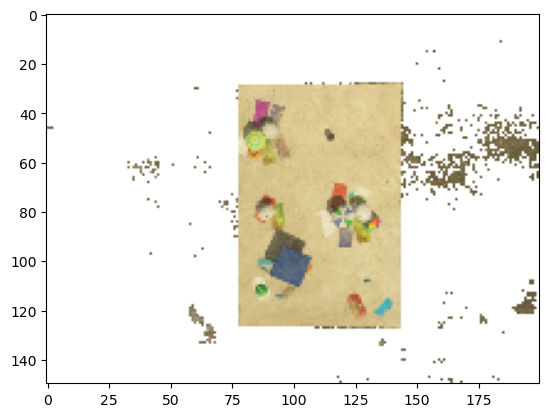

In [38]:
def render_target(apply_deformation=False, translation = None, rotation = None, path=None):
    global SAVEPATH_OUT_IMAGES, GLOBAL_CAM_TRANSLATION, GLOBAL_CAM_ROTATION

    if translation == None:
        translation = torch.tensor([0, -0.4 * 0.0 + 0.025, -0.05 + 0.3])
    if rotation == None:
        rotation = torch.tensor([-80*0.0, 0, 0])

    SAVEPATH_OUT_IMAGES = "test.png"
    if path != None:
        SAVEPATH_OUT_IMAGES = path

    GLOBAL_CAM_TRANSLATION = translation
    GLOBAL_CAM_ROTATION    = rotation
    show_val_frame_offset_small(1, hide_outside=hide_outside_fnc, show_bb=False, forbid=(not apply_deformation))

render_target(apply_deformation=False)
#render_target(apply_deformation=True)

In [39]:
def tilt_gif(apply_deformation=False, single_frame=False, sgl_output=None):
    global SAVEPATH_OUT_IMAGES, GLOBAL_CAM_TRANSLATION, GLOBAL_CAM_ROTATION
    it = 0
    #for alpha in [0.75]:

    for alpha in [0.0]:
        SAVEPATH_OUT_IMAGES = "moved_test/"+str(it)+".png"
        if sgl_output != None:
            SAVEPATH_OUT_IMAGES = sgl_output

        #farm
        GLOBAL_CAM_TRANSLATION = torch.tensor([0, -0.4 * alpha + 0.025, -0.05 + 0.2 * (1.0 - alpha)])
        #beach
        GLOBAL_CAM_TRANSLATION = torch.tensor([0, -0.4 * alpha + 0.025, -0.05 + 0.2 * (1.0 - alpha)])
        
        GLOBAL_CAM_ROTATION    = torch.tensor([-80*alpha, 0, 0])
        show_val_frame_offset_small(1, hide_outside=hide_outside_fnc, show_bb=False, forbid=(not apply_deformation))
        it += 1
        if single_frame:
            break
#tilt_gif(True, True)


<h2>Initialise deformation</h2>

<h3>Initialise deformation to uniform</h3>

In [40]:
from nets import Deform3D as Deform3D
deform_net = Deform3D().cuda()
optimiser = torch.optim.AdamW(deform_net.parameters(), lr=0.001, weight_decay=0.00001)
deform_net.train(True)

def sample_inside_deformed_bb(no_samples, get_offset=True, boundaries_only=False):
    #get_offset: for uniform offset values, linearly increasing offset scale
    samples = torch.rand(no_samples, 3).float()
    if boundaries_only:
        #flick axis to 1 or 0 at random
        zeroing = torch.tensor([1,1,1]).float()
        zeroing[AXIS_TO_OFFSET] *= 0.0
        zeroing = zeroing[None, :]
        indices = torch.randperm(samples.size()[0])
        indices_a = indices[:int(indices.size()[0]/2)]
        indices_b = indices[int(indices.size()[0]/2):]
        #set to zero
        samples[indices_a] *= zeroing
        samples[indices_b] *= zeroing
        #set to one
        samples[indices_b, AXIS_TO_OFFSET] += 1.0

    #in [0, bb_range]^3
    for ax in range(0, 3):
        samples[:,ax] *= (TARGET_BB[1,ax] - TARGET_BB[0,ax])
    
    if get_offset:
        target_offset = samples.clone()
        target_offset *= (1.0 - SCALING_FACTOR)
    
    #scale according to scale factor: axis we e.g. scale to half sohuld be half here
    #we want sample points in the output!
    samples[:,AXIS_TO_OFFSET] *= SCALING_FACTOR
    
    #from [0, bb_range] into BB: translate
    for ax in range(0, 3):
        samples[:,ax] += TARGET_BB[0,ax]

    if get_offset:
        return samples.cuda(), target_offset.cuda()
    else:
        return samples.cuda()
    
def sample_outside_deformed_bb(no_samples, get_offset=True, boundaries_only=False):
    #get_offset: for uniform offset values, linearly increasing offset scale
    samples_a = torch.rand(no_samples, 3).float()
    samples_b = torch.rand(no_samples, 3).float()
    
    samples_a[:,AXIS_TO_OFFSET] -= 1.0
    samples_b[:,AXIS_TO_OFFSET] += 1.0

    #a is in range [-1, 0]
    #b is in range [ 1, 2]

    #make sure we're not just in [0, 1] for the other axis:
    for ax in range(0, 3):
        if ax != AXIS_TO_OFFSET:
            samples_a[:,ax] -= 0.5
            samples_a[:,ax] *= 4.0

            samples_b[:,ax] -= 0.5
            samples_b[:,ax] *= 4.0
    
    samples = torch.cat((samples_a, samples_b), 0)
    max_offset = (1.0 - SCALING_FACTOR)
    target_offset_a = torch.zeros_like(samples_a)
    target_offset_b = torch.ones_like(samples_b) * max_offset
    target_offset = torch.cat((target_offset_a, target_offset_b), 0)

    for ax in range(0, 3):
        if ax == AXIS_TO_OFFSET:
            continue
        target_offset[:,ax] *= 0
    
    #in [0, bb_range]^3
    for ax in range(0, 3):
        samples[:,ax] *= (TARGET_BB[1,ax] - TARGET_BB[0,ax])
    
    if get_offset:
        target_pos = samples.clone()
        target_pos[:,AXIS_TO_OFFSET] *= (1.0 - SCALING_FACTOR)
    
    #scale according to scale factor: axis we e.g. scale to half sohuld be half here
    #we want sample points in the output!
    samples[:,AXIS_TO_OFFSET] *= SCALING_FACTOR
    
    #from [0, bb_range] into BB: translate
    for ax in range(0, 3):
        samples[:,ax] += TARGET_BB[0,ax]

    if get_offset:
        return samples.cuda(), target_pos.cuda()
    else:
        return samples.cuda()

In [41]:
def sample_inside_undeformed_bb(no_samples):
    samples = torch.rand(no_samples, 3).float()
    #in [0, bb_range]^3
    for ax in range(0, 3):
        samples[:,ax] *= (TARGET_BB[1,ax] - TARGET_BB[0,ax])
    
    #from [0, bb_range] into BB: translate
    for ax in range(0, 3):
        samples[:,ax] += TARGET_BB[0,ax]
    return samples.cuda()

In [42]:
if False:
    from helpers import visualise
    tensors_ins, target_offset = sample_inside_deformed_bb(SAMPLES_FOR_INITIALISATION_TRAINING)
    tensors_ins2 = sample_inside_undeformed_bb(SAMPLES_FOR_INITIALISATION_TRAINING)
    c1 = torch.zeros_like(tensors_ins)
    c2 = torch.zeros_like(tensors_ins2)
    c1[:,0] = 1.0
    c2[:,1] = 1.0
    visualise(torch.cat((tensors_ins, tensors_ins2), 0), torch.cat((c1, c2), 0))
    pass

In [43]:
try:
    if RECOMPUTE_ALL:
        goto_exception
    deform_net = torch.load(DEFORMATION_INIT_PATH).to(DEVICE)
    optimiser = torch.optim.AdamW(deform_net.parameters(), lr=0.001, weight_decay=0.00001)
    deform_net.train(True)
    re_learned_deform = False
except Exception as e:
    re_learned_deform = True

    deform_net = Deform3D().to(DEVICE)
    optimiser = torch.optim.AdamW(deform_net.parameters(), lr=0.001, weight_decay=0.00001)
    deform_net.train(True)

    for epoch in range(0, 50):
        avg_loss = 0.0
        for step in range(0, 100):
            optimiser.zero_grad()
            
            tensors, target_offset = sample_inside_deformed_bb(SAMPLES_FOR_INITIALISATION_TRAINING)
            offset = deform_net(tensors)

            tensors_outside, target_offset_outside = sample_outside_deformed_bb(SAMPLES_FOR_INITIALISATION_TRAINING)
            offset_outside = deform_net(tensors_outside)

            loss  = (offset - target_offset[:,AXIS_TO_OFFSET:(AXIS_TO_OFFSET+1)]).square().mean()
            loss  += (offset_outside - target_offset_outside[:,AXIS_TO_OFFSET:(AXIS_TO_OFFSET+1)]).square().mean()
            
            avg_loss += loss.item()
            loss.backward()
            optimiser.step()
        print("*** DONE WITH EPOCH ",epoch," - AVG LOSS: ",avg_loss/100," ***")
        if epoch % 10 == 0:
            print("INITIAL DEFORMATION AFTER ",epoch,":")
            render_target(apply_deformation=False, translation = None, rotation = None, path=None)
            render_target(apply_deformation=True, translation = None, rotation = None, path=None)
            #show_val_frame_offset(hide_outside=hide_outside_fnc)
    torch.save(deform_net, DEFORMATION_INIT_PATH)

<h2>Compute discrete energy field</h2>

<h3>Get points for energy field</h3>

In [44]:
from helpers import visualise

IMG_SCALE_PRE = IMG_SCALE
IMG_SCALE = 0.25
# ---> FIX FOR SCALE TO NOT LOAD BIG <--- #
if os.path.isfile(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_sub.nrg") and not RECOMPUTE_ALL:
    ptc_nrg = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_sub.nrg")
    ptc_pts = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_sub.ptc")
    ptc_dir = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_sub.dir")
    ptc_col = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_sub.col")
    ptc_grd = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_sub.grd")
    ptc_gdt = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_sub.gdt")
else:
    ptc_pts = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}.ptc")
    ptc_dir = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}.dir")
    ptc_col = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}.col")
    ptc_grd = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}.grd")
    ptc_gdt = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}.gdt")

    indices = torch.randperm(ptc_pts.size()[0])[0:5000000]
    ptc_pts = ptc_pts[indices]
    ptc_dir = ptc_dir[indices]
    ptc_gdt = ptc_gdt[indices]
    ptc_grd = ptc_grd[indices]
    ptc_col = ptc_col[indices]

    energy = ptc_grd + ptc_gdt
    energy_filtered = energy.clone()
    energy_filtered_min = energy.clone()
    print("Building KD-Tree...")
    tree = KDTree(ptc_pts) #input [k x 3]
    for k in range(0, energy.size()[0]):
        if k % 50000 == 0:
            print("DONE WITH ",k/energy.size()[0]*100,"%")
        pt = [ptc_pts[k].numpy()]
        _, ii = tree.query(pt, k=20)
        closest = torch.tensor(ii)[0]
        avg = energy[closest].mean()
        energy_filtered[k] = avg

        _, ii = tree.query(pt, k=5)
        energy_filtered_min[k] = energy[closest].min()
    torch.save(energy_filtered_min, f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_sub.nrg")
    torch.save(ptc_pts, f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_sub.ptc")
    torch.save(ptc_dir, f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_sub.dir")
    torch.save(ptc_col, f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_sub.col")
    torch.save(ptc_gdt, f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_sub.gdt")
    torch.save(ptc_grd, f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_sub.grd")

    indices = torch.randperm(ptc_pts.size()[0])[0:100000]
    pts = ptc_pts[indices]
    col = energy_filtered_min[indices]
    col /= col.max()
    col = torch.cat((col[:,None], col[:,None] * 0.0, col[:,None] * 0.0), 1)
    print("Energy filtered:")
    visualise(pts, col, 0.003)

    print("Energy unfiltered:")
    indices = torch.randperm(ptc_pts.size()[0])[0:100000]
    pts = ptc_pts[indices]
    col = energy[indices]
    col /= col.max()
    col = torch.cat((col[:,None], col[:,None] * 0.0, col[:,None] * 0.0), 1)
    visualise(pts, col, 0.003)
    ptc_nrg = energy_filtered_min

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [45]:
indices = get_pt_indices_within_bb(ptc_pts)

ptc_pts_in_bb = ptc_pts[indices].clone()
ptc_dir_in_bb = ptc_dir[indices].clone()
ptc_gdt_in_bb = ptc_gdt[indices].clone()
ptc_grd_in_bb = ptc_grd[indices].clone()
ptc_col_in_bb = ptc_col[indices].clone()

<h2>Learn continuous energy function</h2>

<h3>Generate samples for training</h3>

In [47]:
if os.path.isfile(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_nrg_samples_in_bb.smp") and not RECOMPUTE_ALL: #don't recompute all the time
    nrg_samples_in_bb = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_nrg_samples_in_bb.smp")
    nrg_samples_in_bb_energy = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_nrg_samples_in_bb.nrg")
    recomputed_errors = False
else:
    recomputed_errors = True #re-learn cumulative in next step
    
    #get example prediction network: make sure points in empty space, i.e. bounding box, are also well-defined in terms of energy: assign them closest energy value
    nrg_samples_in_bb = sample_inside_undeformed_bb(1000000).cpu()
    nrg_samples_in_bb_energy = torch.zeros(nrg_samples_in_bb.size()[0])
    print("SAMPLES IN BB: ",nrg_samples_in_bb.size())

    print("Building KD-Tree...")
    tree = KDTree(ptc_pts) #input [k x 3]
    print("Done building KD-Tree.")

    #compute the distance value to neighbours so we know when we fall off in terms of energy:
    ids = torch.randperm(ptc_pts.size()[0])[0:100]
    avg_distance_to_nearest = 0.0
    for k in ids:
        pt = [ptc_pts[k].numpy()]
        _, ii = tree.query(pt, k=1)
        closest = torch.tensor(ii)[0]
        distance = ((ptc_pts[closest] - ptc_pts[k]).square().sum() + 0.000001).sqrt()
        avg_distance_to_nearest += distance
    avg_distance_to_nearest /= ids.size()[0]
    print("Average distance to neighbour: ",avg_distance_to_nearest)

    for k in range(0, nrg_samples_in_bb.size()[0]):
        if k % 50000 == 0:
            print("DONE WITH ",k/nrg_samples_in_bb.size()[0]*100,"%")
        pt = [nrg_samples_in_bb[k].numpy()]
        _, ii = tree.query(pt, k=1)
        closest = torch.tensor(ii)[0]
        distance = ((ptc_pts[closest] - nrg_samples_in_bb[k]).square().sum() + 0.00001).sqrt()
        if distance > 2 * avg_distance_to_nearest:
            nrg_samples_in_bb_energy[k] = 0.0
        else:
            nrg_samples_in_bb_energy[k] = ptc_nrg[closest]
    torch.save(nrg_samples_in_bb, f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_nrg_samples_in_bb.smp")
    torch.save(nrg_samples_in_bb_energy, f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_nrg_samples_in_bb.nrg")
    print("DONE and saved!")

<h3>Train network itself</h3>

In [48]:
if os.path.isfile(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_nrg.net") and not RECOMPUTE_ALL and not recomputed_errors:
    energy_net = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_nrg.net")
    recomputed_energy_net = False
else:
    energy_net = Deform3D().cuda()
    optimiser = torch.optim.AdamW(energy_net.parameters(), lr=0.001, weight_decay=0.00001)
    recomputed_energy_net = True

    for epoch in range(0, 25):
        avg_loss_surface = 0.0
        avg_loss_rnd     = 0.0 
        for step in range(0, 50):
            optimiser.zero_grad()
            if step % 2 == 0:
                indices = torch.randperm(nrg_samples_in_bb.size()[0])[0:25000]

                pts = nrg_samples_in_bb[indices].cuda()
                energy = nrg_samples_in_bb_energy[indices].cuda()

                loss = (energy_net(pts)[:,0] - energy).square().mean() + (energy_net(pts)[:,0] - energy).abs().mean()
                avg_loss_rnd += loss.item()
            else:
                indices = torch.randperm(ptc_pts.size()[0])[0:25000]
                
                pts = ptc_pts[indices].cuda()
                energy = ptc_nrg[indices].cuda()

                loss = (energy_net(pts)[:,0] - energy).square().mean() + (energy_net(pts)[:,0] - energy).abs().mean()
                avg_loss_surface += loss.item()
            loss.backward()
            optimiser.step()

        print("*** DONE WITH EPOCH ",epoch," - AVG ERROR SURFACE: ",avg_loss_surface/25," - AVG ERROR RND: ",avg_loss_rnd/25," ***")
    energy_net.train(False)
    torch.save(energy_net, f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_nrg.net")

<h3>Show continuous energy</h3>

In [49]:
with torch.no_grad():
    indices = torch.randperm(ptc_pts.size()[0])[0:25000]
    a = ptc_pts[indices].cuda()
    indices = get_pt_indices_within_bb(a.cpu())
    a = a[indices]
    energy = energy_net(a)
    energy -= energy.min()
    energy /= energy.max()
    energy = energy.repeat(1,3)
    energy[:,1:] *= 0.0
    
    visualise(a, (energy + 0.0001) ** 1.5, 0.003)
    pass

Output()

<h2>Train cumulative error</h2>

In [50]:
energy_net.train(False)

#iterate:
#   shoot ray through scene
#   accumulate error values across ray
#   train network for it

CUMSUM_STEPS = 100

best_loss = None

if os.path.isfile(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_cum_nrg.net") and not RECOMPUTE_ALL and not recomputed_energy_net:
    cumulative_net = torch.load(f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_cum_nrg.net")
else:
    cumulative_net = Deform3D().cuda()
    optimiser_cum = torch.optim.AdamW(cumulative_net.parameters(), lr=0.001, weight_decay=0.00001)

    for epoch in range(0, 25+1):
        avg_loss     = 0.0 
        its = 0
        for step in range(0, 100):
            optimiser_cum.zero_grad()

            points_surface = ptc_pts_in_bb[torch.randperm(ptc_pts_in_bb.size()[0])[0:100]].cuda()
            points_random  = sample_inside_undeformed_bb(100).cuda()

            points_surface = points_random.clone() # debug

            points_start = torch.cat((points_surface, points_random), 0)
            points_end   = points_start.clone()

            #snap to axis
            points_start[:, AXIS_TO_OFFSET]   = TARGET_BB[0, AXIS_TO_OFFSET]
            points_end[:, AXIS_TO_OFFSET]     = TARGET_BB[1, AXIS_TO_OFFSET] - TARGET_BB[0, AXIS_TO_OFFSET]
            points_start   = points_start[None]
            points_end     = points_end[None]

            linear = torch.range(0.0, 1.0, step=(1.0 / CUMSUM_STEPS))[:,None,None].cuda()
            
            grid = points_start * (1.0 - linear) + points_end * linear#points_start + points_range * linear
            energies_gt = energy_net(grid.view(-1, 3)).detach().view(grid.size()[0], grid.size()[1], -1)
            ##print("ENERGIES GT: ",energies_gt.size())
            energies_gt = energies_gt.cumsum(dim=0).view(-1, 1) / CUMSUM_STEPS
            ##print("ENERGIES GT: ",energies_gt.size())
            #get get values for each
            energies_out = cumulative_net(grid.view(-1, 3))
            
            loss = (energies_gt - energies_out).square().mean()

            avg_loss     += loss.item()

            loss.backward()
            
            optimiser_cum.step()
            its += 1
        avg_loss /= its
        print("DONE WITH EPOCH ",epoch,"/",its," TO LEARN CUMULATIVE ERROR!")
        print("\tAVERAGE LOSS: ",avg_loss)

        if best_loss == None or avg_loss < best_loss:
            print("\t--> new best, saving...")
            best_loss = avg_loss
            torch.save(cumulative_net, f"scene_ptcs/{SCENE_NAME}_sc{IMG_SCALE}_cum_nrg.net")

        if epoch % 25 == 0:
            
            with torch.no_grad():
                indices = torch.randperm(ptc_pts_in_bb.size()[0])[0:25000]
                test_pts = ptc_pts_in_bb[indices].clone().cuda()

                energy = energy_net(test_pts)
                energy -= energy.min()
                energy /= energy.max()
                energy = energy.repeat(1,3)
                energy[:,1:] *= 0.0

                cum_energy = cumulative_net(test_pts)
                cum_energy -= cum_energy.min()
                cum_energy /= cum_energy.max()
                cum_energy = cum_energy.repeat(1,3)
                cum_energy[:,1:] *= 0.0
                
                visualise(test_pts, (energy + 0.0001) ** 1.5, 0.003)
                visualise(test_pts, (cum_energy + 0.0001) ** 1.5, 0.003)
                pass
best_loss = None

In [ ]:
asdf

<h2>Optimise deformation with our approach</h2>

In [ ]:
### load here again for better testing ###
deform_net = torch.load(DEFORMATION_INIT_PATH)
deform_net.train(True)

energy_net.train(False)

IMG_SCALE = IMG_SCALE_PRE

render_gif(apply_deformation=False, single_frame=True, sgl_output="training/base.png")
render_gif(apply_deformation=True, single_frame=True, sgl_output="training/"+str(0)+".png")

### load here again for better testing ###

offset_range = TARGET_BB[1, AXIS_TO_OFFSET] - TARGET_BB[0, AXIS_TO_OFFSET]
offset_range /= 100

#maximum rate of change: meaning, if we go 1 unit in original space, at most go 2 units in deformed space

optimiser = torch.optim.AdamW(deform_net.parameters(), lr=0.001, weight_decay=0.000001)

relu = torch.nn.ReLU()

EPSILON = 0.000001
MAX_STRETCH_FACTOR = SCALING_FACTOR

indices = get_pt_indices_within_bb(ptc_pts)
ptc_pts_in = ptc_pts[indices]
ptc_nrg_in = ptc_nrg[indices]

ptc_nrg_in = ptc_nrg_in / ptc_nrg_in.max()
moved_offset = 0.0

for epoch in range(0, 100):
    #a) Monotonicity:
    #   along an axis, make sure that we do not jump in different directions (=only ever increase the offset, do not decrease it)
    #   (3D: along the normal of a plane, only ever increase)

    #b) Boundaries:
    #   make sure the boundaries are at their target values
    #   meaning: they define the deformation frame (=front and back side of the cube are fixed)

    #c) Gradients:
    #   make sure gradient(deformation) TIMES energy is minimal

    #d) Shearing:
    #   make sure we do not allow any shearing

    #e) Shrinking:
    #   make sure we do not shrink too much (=deformation between two points should have a maximum)

    avg_loss                    = 0.0 # SUM [a to e]

    avg_loss_mono               = 0.0 #a) 
    avg_loss_boundaries         = 0.0 #b)
    avg_loss_gradients          = 0.0 #c)
    avg_loss_shearing           = 0.0 #d)
    avg_loss_cap_deformation    = 0.0 #e)

    avg_distance_inverting_offset = 0.0

    lambdas = dict()
    lambdas['mono']   =    1.0
    lambdas['bound']  =  100.0
    lambdas['grad']   =   10.0
    lambdas['cap']    =    0.0
    lambdas['shear']  =    0.1

    iterations_for_optimisation = 100
    
    for step in range(0, iterations_for_optimisation):
        optimiser.zero_grad()
        
        #always combine: some random points, some surface points ("importance sampling")
        samples_random_unit = (torch.rand(SAMPLES_FOR_INITIALISATION_TRAINING, 3, device=DEVICE) * 2.0 - 1.0) * 2.0
        samples_random_bb   = sample_inside_undeformed_bb(SAMPLES_FOR_INITIALISATION_TRAINING, False)
        samples_random_bb_nrg = torch.zeros_like(samples_random_bb)[:,0].cuda()
        
        indices = torch.randperm(ptc_pts.size()[0])[0:SAMPLES_FOR_INITIALISATION_TRAINING]
        samples_surface_pts = ptc_pts[indices].clone().cuda()
        samples_surface_nrg = ptc_nrg[indices].clone().cuda()

        indices = torch.randperm(ptc_pts_in.size()[0])[0:SAMPLES_FOR_INITIALISATION_TRAINING]
        samples_surface_pts_in = ptc_pts_in[indices].clone().cuda()
        samples_surface_nrg_in = ptc_nrg_in[indices].clone().cuda()
        
        loss_mono            = torch.zeros(1, device=DEVICE)
        loss_boundaries      = torch.zeros(1, device=DEVICE)
        loss_gradients       = torch.zeros(1, device=DEVICE)
        loss_shearing        = torch.zeros(1, device=DEVICE)
        loss_cap_deformation = torch.zeros(1, device=DEVICE)

        #in post-deformation space
        pts_surface = samples_surface_pts_in.clone()
        pts_inside  = sample_inside_undeformed_bb(pts_surface.size()[0])
        pts_mixed = torch.cat((pts_surface, pts_inside), 0)

        #a) Monotonicity:
        #   along an axis, make sure that we do not jump in different directions (=only ever increase the offset, do not decrease it)
        #   (3D: along the normal of a plane, only ever increase)
        if True:
            pts_mixed_offset = pts_mixed.clone()
            offset = torch.zeros_like(pts_mixed)
            offset[:,AXIS_TO_OFFSET] = torch.rand_like(offset[:,AXIS_TO_OFFSET]) * offset_range + offset_range
            pts_mixed_offset = pts_mixed_offset + offset
            #monotonically falling:
            if SCALING_FACTOR < 1.0:
                loss_mono = (relu(deform_net(pts_mixed.clone())-deform_net(pts_mixed_offset)) / offset.sum(dim=1)[:,None]).mean()
            elif SCALING_FACTOR > 1.0:
                loss_mono = (relu(deform_net(pts_mixed_offset) - deform_net(pts_mixed.clone())) / offset.sum(dim=1)[:,None]).mean()
        
        #b) Boundaries:
        #   make sure the boundaries are at their target values
        #   meaning: they define the deformation frame (=front and back side of the cube are fixed)
        #       part a: boundarie values should be correct
        #       part b: stuff outside should be correct
        if True:
            tensors, target_offset = sample_inside_deformed_bb(SAMPLES_FOR_INITIALISATION_TRAINING)
            offset = deform_net(tensors)

            tensors_outside, target_offset_outside = sample_outside_deformed_bb(SAMPLES_FOR_INITIALISATION_TRAINING)
            offset_outside = deform_net(tensors_outside)

            loss_boundaries  = (offset - target_offset[:,AXIS_TO_OFFSET:(AXIS_TO_OFFSET+1)]).square().mean()
            loss_boundaries  = loss_boundaries + (offset_outside - target_offset_outside[:,AXIS_TO_OFFSET:(AXIS_TO_OFFSET+1)]).square().mean()
        
        #c) Gradients NEW FORMULATION:
        if True:
            #1. get rate of change in the offset, i.e. how large the jump for one point is
            #surface_points_post_deform are now those points that are mapped ONTO our features
            ptcs_for_grad = pts_mixed.clone()

            offset_axis = torch.zeros_like(ptcs_for_grad)
            offset_axis[:,AXIS_TO_OFFSET] = offset_range
            
            #compute offset for a point and the offset version of the point
            D_ptc_offset = deform_net(ptcs_for_grad.clone())
            D_ptc_eps_offset = deform_net(ptcs_for_grad.clone() + offset_axis)

            D_ptc = ptcs_for_grad.clone()
            D_ptc[:,AXIS_TO_OFFSET:(AXIS_TO_OFFSET+1)] += D_ptc_offset
            D_ptc_eps = ptcs_for_grad.clone() + offset_axis
            D_ptc_eps[:,AXIS_TO_OFFSET:(AXIS_TO_OFFSET+1)] += D_ptc_eps_offset
            
            #compute the change magnitude of the offset
            change_in_offset = (D_ptc_eps_offset - D_ptc_offset).abs().sum(dim=-1) / offset_range

            #compute the energy value between the two points - if it's high, we don't want to do deformation here
            energy_a   = cumulative_net(D_ptc.clone())[:,0].detach()
            energy_b   = cumulative_net(D_ptc_eps.clone())[:,0].detach()

            energy = (energy_a - energy_b).abs()
            
            loss_gradients = (energy * change_in_offset).mean()

        #e) Shearing:
        #   make sure we do not allow any shearing for surface points WITH HIGH ENERGY
        if True:
            ptcs_for_shear = pts_surface.clone()

            offset_range_rnd = offset_range * 0.01 + offset_range * torch.rand_like(offset_range)
            #make sure deformation for neighbouring is the same
            offset_axis_a = torch.zeros_like(ptcs_for_shear)
            offset_axis_b = torch.zeros_like(ptcs_for_shear) #will be z-axis if we don't explicitly use z axis
            it = 0
            #increase all axis BUT the main axis of deformation - shearing is NEVER on that axis, but on all others!
            #WE DO TWO DIRECTIONS OF SHEARING!!!!
            for ax in range(0, 3):
                if ax == AXIS_TO_OFFSET:
                    continue
                else:
                    if it == 0:
                        offset_axis_a[:,ax] = offset_range_rnd
                        it += 1
                    else:
                        offset_axis_b[:,ax] = offset_range_rnd
            
            #compare deformation at our base point versus the two points on the other axis
            deform_base = deform_net(ptcs_for_shear.clone())
            deform_a = deform_net(ptcs_for_shear.clone() + offset_axis_a.detach())
            deform_b = deform_net(ptcs_for_shear.clone() + offset_axis_b.detach())

            loss_shearing = ((deform_base - deform_a).abs() + (deform_base - deform_b).abs()).mean(dim=1)
            loss_shearing = loss_shearing / offset_range_rnd
            #get energy of the deformed point: if it has shearing, but low energy, we should not care much
            energy_points = ptcs_for_shear.clone()
            energy_points[:,AXIS_TO_OFFSET:(AXIS_TO_OFFSET+1)] += deform_base
            nrg = torch.nn.functional.relu(energy_net(energy_points).detach()[:,0])
            loss_shearing = (loss_shearing * nrg).mean()
            
        loss =  loss_mono * lambdas['mono'] +\
                loss_gradients * lambdas['grad'] +\
                loss_boundaries * lambdas['bound'] +\
                loss_shearing * lambdas['shear'] +\
                loss_cap_deformation * lambdas['cap']

        avg_loss_mono += loss_mono.item()
        avg_loss_boundaries += loss_boundaries.item()
        avg_loss_gradients += loss_gradients.item()
        avg_loss_shearing += loss_shearing.item()
        avg_loss_cap_deformation += loss_cap_deformation.item()
        avg_loss += loss.item()

        loss.backward()

        optimiser.step()
    
    print("*** DONE WITH EPOCH ",epoch," ***")
    print("\t\inverse offset accuracy: ",avg_distance_inverting_offset/iterations_for_optimisation)
    print("\tavg error: ",avg_loss/float(iterations_for_optimisation)," - components: ")
    print("\t\t",lambdas['mono']," * ",avg_loss_mono/float(iterations_for_optimisation)," = ",lambdas['mono']*avg_loss_mono/float(iterations_for_optimisation),"(mono)")
    print("\t\t",lambdas['bound']," * ",avg_loss_boundaries/float(iterations_for_optimisation)," = ",lambdas['bound']*avg_loss_boundaries/float(iterations_for_optimisation),"(bound)")
    print("\t\t",lambdas['grad']," * ",avg_loss_gradients/float(iterations_for_optimisation)," = ",lambdas['grad']*avg_loss_gradients/float(iterations_for_optimisation),"(grad)")
    print("\t\t",lambdas['cap']," * ",avg_loss_cap_deformation/float(iterations_for_optimisation)," = ",lambdas['cap']*avg_loss_cap_deformation/float(iterations_for_optimisation),"(cap)")
    print("\t\t",lambdas['shear']," * ",avg_loss_shearing/float(iterations_for_optimisation)," = ",lambdas['shear']*avg_loss_shearing/float(iterations_for_optimisation),"(shear)")
    # loss_beginning + loss_ending + loss_others + loss_outside

    if (epoch % 5 == 0 and epoch != 0) or True:
        print("OPTIMISED DEFORMATION AFTER ",epoch,":")
        tilt_gif(apply_deformation=True, single_frame=True, sgl_output="training/"+str(epoch+1)+".png")

#visualise(ptc_pts[indices].transpose(0,1).contiguous(), ptc_col[indices].transpose(0,1).contiguous(), 0.0005)
for k in range(0, 5):
    break
    render_gif(apply_deformation=True, single_frame=True, sgl_output="training/"+str(epoch+1+k)+".png")

In [ ]:
render_gif(apply_deformation=True, single_frame=False)
asdf

In [ ]:
ptcs_for_shear.size()

<h1>Visualise deformation field</h1>

In [ ]:
with torch.no_grad():
    #deform_net = torch.load(f"nets/{SCENE_NAME}_ax{AXIS_TO_OFFSET}_cmp{SCALING_FACTOR}_sc{IMG_SCALE}_deform_init.net")
    indices = torch.randperm(ptc_pts_in.size()[0])[0:1000000]
    subset = ptc_pts_in[indices].clone()
    deformations = deform_net(subset.cuda()).cpu().view(-1)
    subset[:,AXIS_TO_OFFSET] += deformations
    deformations = deformations[:,None].repeat(1,3)
    deformations -= deformations.min()
    deformations /= deformations.max()
    deformations = deformations * 2.0
    deformations = deformations.clamp(0.0, 1.0)
    subset[:,2] *= 0.0
    #print(subset.size())
    #print(deformations.size())
    visualise(subset, deformations, pt_size=0.005)

In [ ]:
offset_range_rnd = offset_range * 0.01 + offset_range * torch.rand_like(offset_range)
#make sure deformation for neighbouring is the same
offset_axis_a = torch.zeros_like(ptcs_for_shear)
offset_axis_b = torch.zeros_like(ptcs_for_shear) #will be z-axis if we don't explicitly use z axis
it = 0
#increase all axis BUT the main axis of deformation - shearing is NEVER on that axis, but on all others!
#WE DO TWO DIRECTIONS OF SHEARING!!!!
for ax in range(0, 3):
    if ax == AXIS_TO_OFFSET:
        continue
    else:
        if it == 0:
            offset_axis_a[:,ax] = offset_range_rnd
            it += 1
        else:
            offset_axis_b[:,AXIS_TO_OFFSET] = offset_range_rnd

#compare deformation at our base point versus the two points on the other axis
deform_base = deform_net(ptcs_for_shear.clone())
deform_a = deform_net(ptcs_for_shear.clone() + offset_axis_a.detach())
deform_b = deform_net(ptcs_for_shear.clone() + offset_axis_b.detach())

deformation_magnitude = ((deform_base - deform_a).abs() + (deform_base - deform_b).abs()).mean(dim=1)
#print("SHEAR: ",loss_shearing.size())
loss_shearing = deformation_magnitude / offset_range_rnd
#print("DIV: ",loss_shearing.size())
energy_points = ptcs_for_shear.clone()
energy_points[:,AXIS_TO_OFFSET:(AXIS_TO_OFFSET+1)] += deform_base
nrg = torch.nn.functional.relu(energy_net(energy_points).detach()[:,0])
loss_shearing_total = (loss_shearing * nrg)

In [ ]:
nrg.size()

In [ ]:
ptcs_for_shear_offset[:,2].min()

In [ ]:
with torch.no_grad():
    ptcs_for_shear_offset = ptcs_for_shear.clone()
    ptcs_for_shear_offset[:,AXIS_TO_OFFSET] += deform_net(ptcs_for_shear_offset.clone())[:,0]
    
    v_nrg = nrg.clone()[:,None].repeat(1,3)
    v_nrg -= v_nrg.min()
    v_nrg /= v_nrg.max()
    v_nrg[:,1:] *= 0.0 
    visualise(ptcs_for_shear_offset, v_nrg, pt_size=0.001)
    
    v_nrg = deformation_magnitude.clone()[:,None].repeat(1,3)
    v_nrg -= v_nrg.min()
    v_nrg /= v_nrg.max()
    v_nrg[:,1:] *= 0.0 
    visualise(ptcs_for_shear_offset, v_nrg, pt_size=0.001)

    v_nrg = loss_shearing_total.clone()[:,None].repeat(1,3)
    v_nrg -= v_nrg.min()
    v_nrg /= v_nrg.max()
    v_nrg[:,1:] *= 0.0 
    visualise(ptcs_for_shear_offset, v_nrg, pt_size=0.001)
    pass

In [ ]:
render_gif(apply_deformation=True, single_frame=False)
asdf

In [ ]:
deformations.size()

In [ ]:
range_x = TARGET_BB[1,0] - TARGET_BB[0,0]
range_y = TARGET_BB[1,1] - TARGET_BB[0,1]

size_factor = range_x / range_y
print(size_factor)

In [ ]:
subset.size()[0]

In [ ]:
deformations.size()

In [ ]:
grid_pts = []
for x in range(0, 200):
    grid_pts.append([])
    for y in range(0, int(size_factor * 200)):
        grid_pts[x].append([])
for k in range(0, subset.size()[0]):
    #get position & value
    x = (ptc_pts_in[k,1] - TARGET_BB[0,1]) / range_y * 200
    y = (ptc_pts_in[k,0] - TARGET_BB[0,0]) / range_x * 200 * size_factor
    x = int(x.item())
    y = int(y.item())
    if x > 199 or y > int(size_factor * 200 - 1):
        continue
    grid_pts[x][y].append(deformations[k,0].item())
    if k % 10000 == 0:
        print("DONE WITH ",k,"/",subset.size()[0])

In [ ]:
import statistics

img = torch.ones(1, len(grid_pts), len(grid_pts[0])) * -1
lrimg = torch.ones(1, int(len(grid_pts)/10+1), int(len(grid_pts[0])/10)+1) * -1
for x in range(0, len(grid_pts)):
    for y in range(0, len(grid_pts[0])):
        if len(grid_pts[x][y]) == 0:
            continue
        img[0,x,y] = statistics.median(grid_pts[x][y])
        lrimg[0,int(x/10),int(y/10)] = statistics.median(grid_pts[x][y])

In [ ]:
show(img.repeat(3,1,1))
show(lrimg.repeat(3,1,1))

In [ ]:
deform_net = torch.load(f"nets/{SCENE_NAME}_ax{AXIS_TO_OFFSET}_cmp{SCALING_FACTOR}_sc0.25_deform_init.net")
render_gif(apply_deformation=True, single_frame=False)

In [ ]:
#deformation field: 

In [ ]:
def show_deformation():
    with torch.no_grad():
        range_x = TARGET_BB[1,0] - TARGET_BB[0,0]
        range_y = TARGET_BB[1,1] - TARGET_BB[0,1]
        range_x, range_y

        median_height = ptc_pts[:,2].median()

        stepsize = max(range_x.item(), range_y.item())/100

        image = torch.zeros(int(range_x/stepsize), int(range_y/stepsize))
        pts_to_lookup = torch.zeros(0, 3)
        for x in range(0, image.size()[0]):
            for y in range(0, image.size()[1]):
                xpos = x * stepsize
                ypos = y * stepsize
                lookup = torch.tensor([xpos, ypos, median_height])[None, :]
                pts_to_lookup = torch.cat((pts_to_lookup, lookup), 0)
                #image[x,y] = deform_net(lookup).item()
        
        image = deform_net(pts_to_lookup.cuda()).cpu().view(image.size()[0], image.size()[1])

        print(image.size())
        image -= image.min()
        image /= image.max()
        image = image[None].repeat(3,1,1)
        show(image.transpose(1,2))

show_deformation()

In [ ]:
deform_net = torch.load(f"nets/{SCENE_NAME}_ax{AXIS_TO_OFFSET}_cmp{SCALING_FACTOR}_sc0.25_deform_init.net")
render_gif(apply_deformation=True, single_frame=False)

In [ ]:
asdf